In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
import requests

import pymongo
from pymongo import MongoClient
from pprint import pprint


'''
Mongo shell commands to create geoloc field in each document and create an index on geoloc

db.Yelp.aggregate([
   { $addFields: { 
    geoloc: {
      "type" : "Point",
      "coordinates" : [
        {"$toDecimal" : "$longitude"},
        {"$toDecimal" : "$latitude"}
        ]
      }
    }
  },
  { $out : "YelpGeo" }
])

db.Yelp.createIndex( { geoloc : "2dsphere" } )
'''

'\nMongo shell commands to create geoloc field in each document and create an index on geoloc\n\ndb.Yelp.aggregate([\n   { $addFields: { \n    geoloc: {\n      "type" : "Point",\n      "coordinates" : [\n        {"$toDecimal" : "$longitude"},\n        {"$toDecimal" : "$latitude"}\n        ]\n      }\n    }\n  },\n  { $out : "YelpGeo" }\n])\n\ndb.Yelp.createIndex( { geoloc : "2dsphere" } )\n'

# PyMongo Setup and Querying

In [51]:
client = MongoClient()
db = client['DS4300']
yelp_collection = db['YelpGeo']

In [52]:
# Example document
pprint(yelp_collection.find_one())

{'_id': ObjectId('622198b2b5127b859164a21e'),
 'address': '921 Pearl St',
 'attributes': {'Alcohol': "'beer_and_wine'",
                'Ambience': "{'touristy': False, 'hipster': False, 'romantic': "
                            "False, 'divey': False, 'intimate': False, "
                            "'trendy': False, 'upscale': False, 'classy': "
                            "False, 'casual': True}",
                'BikeParking': 'True',
                'BusinessAcceptsBitcoin': 'False',
                'BusinessAcceptsCreditCards': 'True',
                'BusinessParking': "{'garage': False, 'street': True, "
                                   "'validated': False, 'lot': False, 'valet': "
                                   'False}',
                'Caters': 'True',
                'DogsAllowed': 'False',
                'GoodForMeal': "{'dessert': False, 'latenight': False, "
                               "'lunch': False, 'dinner': False, 'brunch': "
                              

#### Q1. How many establishments have 5 stars?

In [53]:
num_5_stars = yelp_collection.find({'stars': 5})
len(list(num_5_stars))

19953

#### Q2. Which establishment has the least stars?

In [133]:
least_stars = yelp_collection.find_one(sort=[('stars', 1)])
print(least_stars['name'] + ', ' + least_stars['city'])

Magical Pizza Express, Orlando


#### Q3. What is the count of establishments for each star rating?

In [134]:
star_counts = yelp_collection.aggregate(
        [{"$group" : 
            {"_id" : "$stars", 
            "num_establishments" : {"$sum" : 1}
         }},
         {'$sort' : 
            {'_id' : 1}}
    ])
    
for i in star_counts:
    pprint(i)

{'_id': 1, 'num_establishments': 1686}
{'_id': 1.5, 'num_establishments': 4157}
{'_id': 2, 'num_establishments': 8523}
{'_id': 2.5, 'num_establishments': 13720}
{'_id': 3, 'num_establishments': 21583}
{'_id': 3.5, 'num_establishments': 28835}
{'_id': 4, 'num_establishments': 34056}
{'_id': 4.5, 'num_establishments': 28072}
{'_id': 5, 'num_establishments': 19953}


#### Q4. What is the count of establishments for each star rating specifically in Boston?

In [135]:
boston_star_counts = yelp_collection.aggregate(
        [
            { '$match' : { 'city' : 'Boston' } },
            {"$group" : 
                {"_id" : "$stars", 
                "num_establishments" : {"$sum" : 1}
                }
            },
            {'$sort' : {'_id' : 1}}
    ])
    
for i in boston_star_counts:
    pprint(i)

{'_id': 1, 'num_establishments': 97}
{'_id': 1.5, 'num_establishments': 194}
{'_id': 2, 'num_establishments': 395}
{'_id': 2.5, 'num_establishments': 705}
{'_id': 3, 'num_establishments': 1233}
{'_id': 3.5, 'num_establishments': 1674}
{'_id': 4, 'num_establishments': 1788}
{'_id': 4.5, 'num_establishments': 1312}
{'_id': 5, 'num_establishments': 865}


#### Q5. What is the average star count and the total number of reviews for each city?

In [136]:
avg_stars_per_city_and_counts = yelp_collection.aggregate(
        [
            {"$group" : 
                {"_id" : "$city", 
                "avg_stars" : {"$avg" : "$stars"},
                "num_reviews" : {"$sum" : 1}
            }},
            
            # {"$group" :
            #     {"_id" : "$avg_stars",
            #     "count" : {"$sum" : 1}}},
                        
            {'$sort' : {'num_reviews' : -1}},
    ])
    
for i in avg_stars_per_city_and_counts:
    pprint(i)

{'_id': 'Austin', 'avg_stars': 3.8545681655960027, 'num_reviews': 22416}
{'_id': 'Portland', 'avg_stars': 3.9191342086469265, 'num_reviews': 18203}
{'_id': 'Vancouver', 'avg_stars': 3.611515378844711, 'num_reviews': 13330}
{'_id': 'Atlanta', 'avg_stars': 3.523826514430701, 'num_reviews': 12612}
{'_id': 'Orlando', 'avg_stars': 3.5376045877597067, 'num_reviews': 10637}
{'_id': 'Boston', 'avg_stars': 3.6160595425390296, 'num_reviews': 8263}
{'_id': 'Columbus', 'avg_stars': 3.54009647271631, 'num_reviews': 6634}
{'_id': 'Boulder', 'avg_stars': 3.7793076317859953, 'num_reviews': 2542}
{'_id': 'Cambridge', 'avg_stars': 3.6496095355528153, 'num_reviews': 2433}
{'_id': 'Beaverton', 'avg_stars': 3.6949378330373004, 'num_reviews': 2252}
{'_id': 'Richmond', 'avg_stars': 3.2959240647682857, 'num_reviews': 1791}
{'_id': 'Burnaby', 'avg_stars': 3.3594202898550725, 'num_reviews': 1725}
{'_id': 'Kissimmee', 'avg_stars': 3.3228254524226504, 'num_reviews': 1713}
{'_id': 'Decatur', 'avg_stars': 3.5155917

#### Q6. What is the distribution of average star counts for each city?

In [147]:
avg_stars_per_city = yelp_collection.aggregate(
        [
            {"$group" : 
                {"_id" : "$city",
                    "latitude" : {"$avg" : "$latitude"},
                    "longitude" : {"$avg" : "$longitude"},
                    "avg_stars" : {"$avg" : "$stars"}
                }
            },
            
            # {"$group" :
            #     {"_id" : "$avg_stars",
            #         "count" : {"$sum" : 1}
            #     }
            # },
                        
            # {'$sort' : {'num_reviews' : -1}}
    ])

avg_stars_list = list(avg_stars_per_city)
    
for i in avg_stars_list:
    pprint(i)

len(avg_stars_list)


{'_id': 'Altamonte Springs',
 'avg_stars': 3.4731800766283527,
 'latitude': 28.6647602866696,
 'longitude': -81.39371811195926}
{'_id': 'Ocoee',
 'avg_stars': 3.577639751552795,
 'latitude': 28.556479655476085,
 'longitude': -81.53176501550652}
{'_id': 'Spring Valley',
 'avg_stars': 5.0,
 'latitude': 42.4114714,
 'longitude': -71.012537}
{'_id': 'Prontland',
 'avg_stars': 5.0,
 'latitude': 45.455382,
 'longitude': -122.5861553}
{'_id': 'E Boston',
 'avg_stars': 3.5,
 'latitude': 42.3735248,
 'longitude': -71.0406306}
{'_id': 'San dy',
 'avg_stars': 4.5,
 'latitude': 45.4638103718,
 'longitude': -122.5795161724}
{'_id': 'Sandy springs',
 'avg_stars': 5.0,
 'latitude': 33.942129,
 'longitude': -84.3753151}
{'_id': 'longwood',
 'avg_stars': 4.666666666666667,
 'latitude': 28.688164933333336,
 'longitude': -81.35618583333333}
{'_id': 'DeBary',
 'avg_stars': 3.7142857142857144,
 'latitude': 28.885020889889287,
 'longitude': -81.30818119648929}
{'_id': 'Doctor Phillips',
 'avg_stars': 3.0,
 

836

Text(0.5, 0, 'Average Stars')

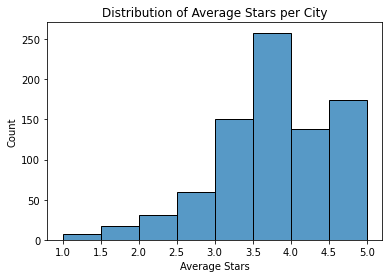

In [148]:
# Process PyMongo output for data visualization

avg_star_data = []
lat_data = []
long_data = []

for record in avg_stars_list:
    # print(record['avg_stars'])
    # print(type(record['avg_stars']))
    avg_star_data.append(record['avg_stars'])
    lat_data.append(record['latitude'])
    long_data.append(record['longitude'])

len(avg_star_data)
# avg_stars_per_city

sns.histplot(x=avg_star_data, bins=8)
plt.title('Distribution of Average Stars per City')
plt.xlabel('Average Stars')

Text(13.34333333333334, 0.5, 'Latitude')

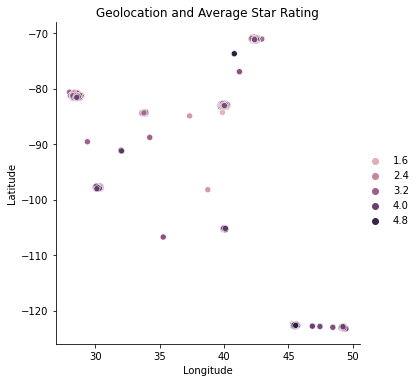

In [167]:
scatter = sns.relplot(x=lat_data, y=long_data, hue=avg_star_data, legend=True)
plt.title('Geolocation and Average Star Rating')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#### Q7. How many locations are within 5000 meters of Mr G's Pizza & Subs

In [140]:
target = yelp_collection.find_one({'name' : 'Mr G\'s Pizza & Subs'})['geoloc']

res = yelp_collection.find({
    "geoloc": {
        '$near': {
            '$geometry':
                target,
                '$maxDistance': 5000
        }
    }
})

len(list(res))

1122

#### Q8.

#### Q9. 

##### Q10. 